## Physics Informed Neural Networks to Approximate Solution of PDEs

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$


with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [13]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.6],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        grad_u_sq_x = torch.autograd.grad(grad_u_xx.sum(), input_int, create_graph=True)[0][:,1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


In [14]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

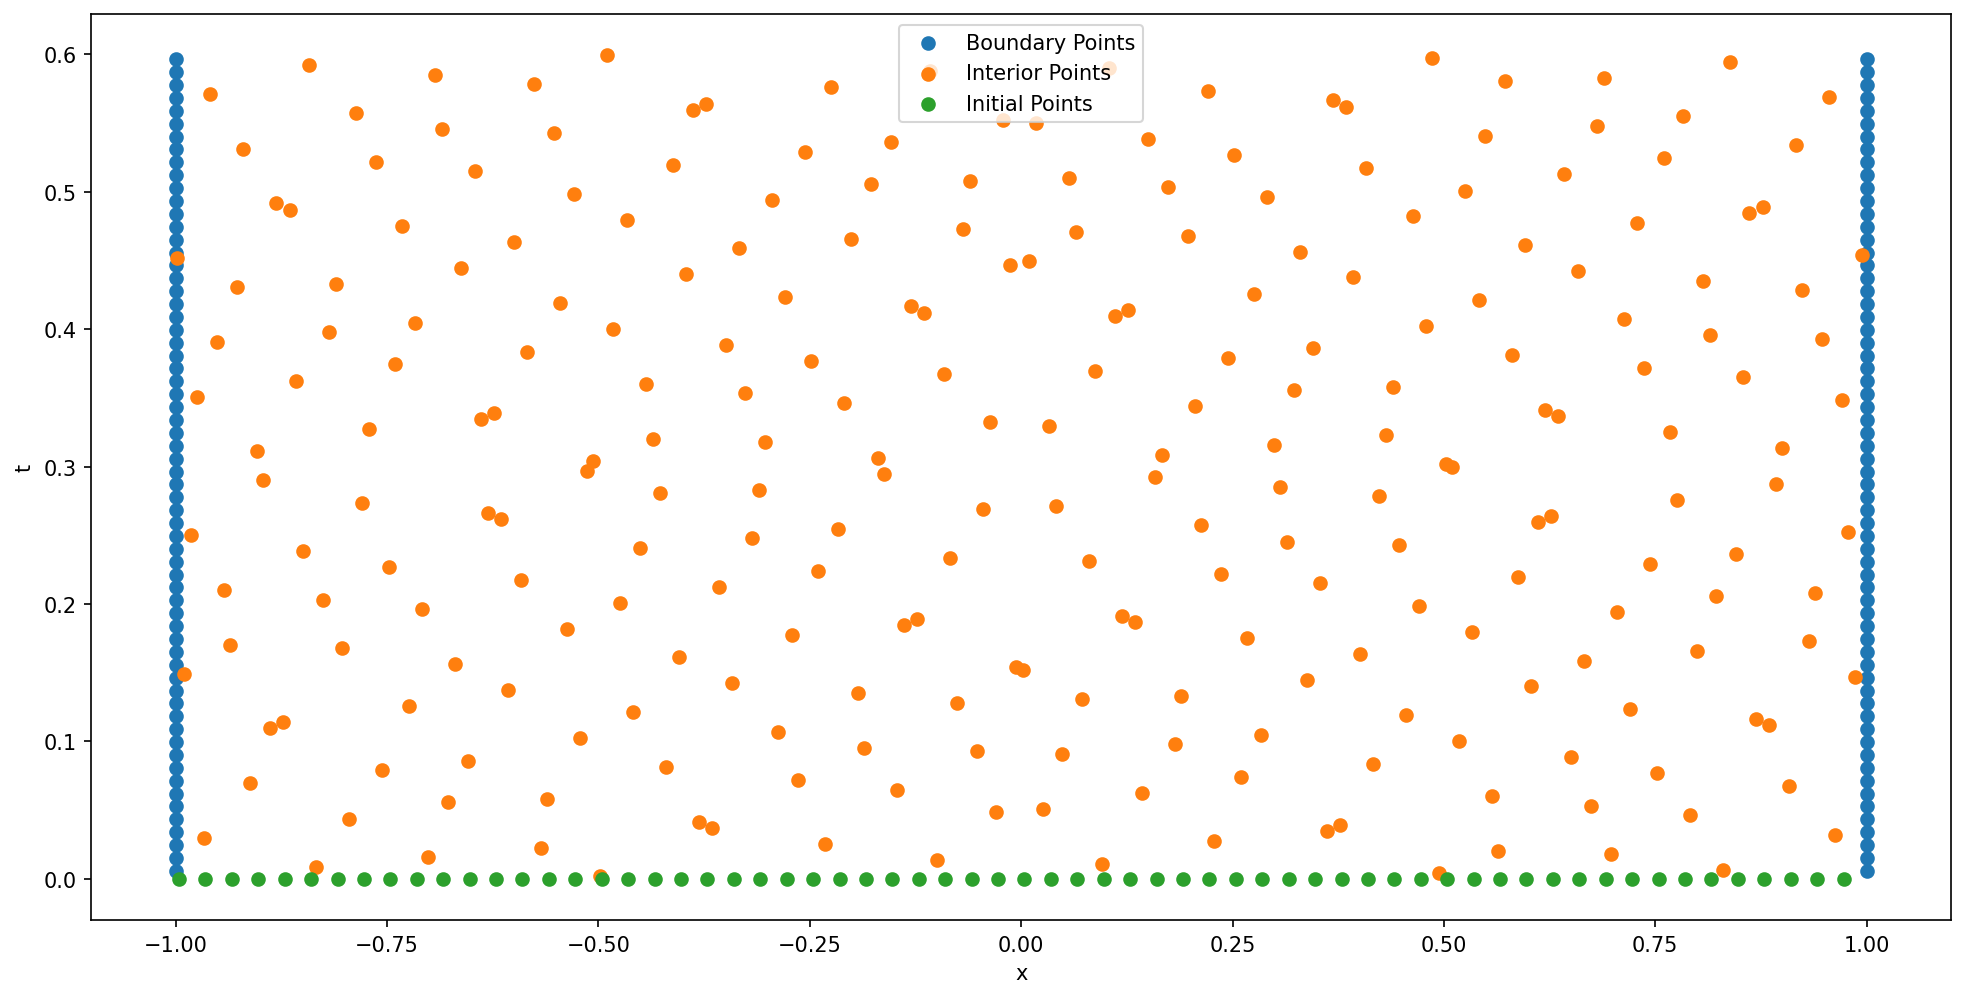

In [15]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [16]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  1.5613 | PDE Loss:  0.3077 | Function Loss:  1.2072
Total loss:  1.4913 | PDE Loss:  0.226 | Function Loss:  1.1513
Total loss:  1.2927 | PDE Loss:  0.1691 | Function Loss:  0.6867
Total loss:  1.1611 | PDE Loss:  0.0286 | Function Loss:  0.5811
Total loss:  1.5439 | PDE Loss:  0.4642 | Function Loss:  0.7685
Total loss:  0.9226 | PDE Loss:  -0.2081 | Function Loss:  0.3374
Total loss:  0.8295 | PDE Loss:  -0.2897 | Function Loss:  0.2098
Total loss:  0.6848 | PDE Loss:  -0.4076 | Function Loss:  -0.0329
Total loss:  0.6451 | PDE Loss:  -0.4317 | Function Loss:  -0.1451
Total loss:  0.5332 | PDE Loss:  -0.5277 | Function Loss:  -0.3503
Total loss:  0.4889 | PDE Loss:  -0.5868 | Function Loss:  -0.3072
Total loss:  0.4244 | PDE Loss:  -0.6602 | Function Loss:  -0.3277
Total loss:  0.3654 | PDE Loss:  -0.7158 | Function Loss:  -0.4028
Total loss:  0.3375 | PDE Loss:  -0.7474 | Function Loss:  -0.4131
Total

Total loss:  -2.2628 | PDE Loss:  -4.0154 | Function Loss:  -2.3472
Total loss:  -2.2701 | PDE Loss:  -4.0339 | Function Loss:  -2.3522
Total loss:  -2.2776 | PDE Loss:  -4.013 | Function Loss:  -2.3659
Total loss:  -2.2862 | PDE Loss:  -4.0345 | Function Loss:  -2.3716
Total loss:  -2.3035 | PDE Loss:  -4.1116 | Function Loss:  -2.3769
Total loss:  -2.3184 | PDE Loss:  -4.1703 | Function Loss:  -2.3842
Total loss:  -2.3345 | PDE Loss:  -4.2007 | Function Loss:  -2.398
Total loss:  -2.3474 | PDE Loss:  -4.1774 | Function Loss:  -2.4169
Total loss:  -2.3584 | PDE Loss:  -4.1698 | Function Loss:  -2.4313
Total loss:  -2.3699 | PDE Loss:  -4.1632 | Function Loss:  -2.4461
Total loss:  -2.3846 | PDE Loss:  -4.1657 | Function Loss:  -2.4632
Total loss:  -2.405 | PDE Loss:  -4.1342 | Function Loss:  -2.4947
Total loss:  -2.4317 | PDE Loss:  -4.1482 | Function Loss:  -2.5243
Total loss:  -2.4517 | PDE Loss:  -4.1489 | Function Loss:  -2.549
Total loss:  -2.4647 | PDE Loss:  -4.173 | Function 

Total loss:  -3.2407 | PDE Loss:  -5.1212 | Function Loss:  -3.302
Total loss:  -3.2492 | PDE Loss:  -5.1347 | Function Loss:  -3.3097
Total loss:  -3.2626 | PDE Loss:  -5.1536 | Function Loss:  -3.3223
Total loss:  -3.2809 | PDE Loss:  -5.1706 | Function Loss:  -3.3408
Total loss:  -3.2993 | PDE Loss:  -5.1821 | Function Loss:  -3.3603
Total loss:  -3.3122 | PDE Loss:  -5.1763 | Function Loss:  -3.376
Total loss:  -3.3197 | PDE Loss:  -5.1774 | Function Loss:  -3.3846
Total loss:  -3.3223 | PDE Loss:  -5.1744 | Function Loss:  -3.3881
Total loss:  -3.3236 | PDE Loss:  -5.1762 | Function Loss:  -3.3893
Total loss:  -3.3243 | PDE Loss:  -5.1784 | Function Loss:  -3.3898
Total loss:  -3.3248 | PDE Loss:  -5.1797 | Function Loss:  -3.3902
Total loss:  -3.3255 | PDE Loss:  -5.1807 | Function Loss:  -3.3908
Total loss:  -3.3264 | PDE Loss:  -5.1818 | Function Loss:  -3.3917
Total loss:  -3.3275 | PDE Loss:  -5.1798 | Function Loss:  -3.3932
Total loss:  -3.3291 | PDE Loss:  -5.1776 | Functi

Total loss:  -3.7969 | PDE Loss:  -5.2216 | Function Loss:  -4.0018
Total loss:  -3.7976 | PDE Loss:  -5.2243 | Function Loss:  -4.0012
Total loss:  -3.7982 | PDE Loss:  -5.2249 | Function Loss:  -4.0018
Total loss:  -3.799 | PDE Loss:  -5.2249 | Function Loss:  -4.0032
Total loss:  -3.7999 | PDE Loss:  -5.223 | Function Loss:  -4.0058
Total loss:  -3.8008 | PDE Loss:  -5.2197 | Function Loss:  -4.0093
Total loss:  -3.8019 | PDE Loss:  -5.2164 | Function Loss:  -4.013
Total loss:  -3.8031 | PDE Loss:  -5.2113 | Function Loss:  -4.0182
Total loss:  -3.8047 | PDE Loss:  -5.2069 | Function Loss:  -4.0237
Total loss:  -3.8067 | PDE Loss:  -5.2016 | Function Loss:  -4.0306
Total loss:  -3.8097 | PDE Loss:  -5.1982 | Function Loss:  -4.0379
Total loss:  -3.8133 | PDE Loss:  -5.1954 | Function Loss:  -4.046
Total loss:  -3.8189 | PDE Loss:  -5.1992 | Function Loss:  -4.0529
Total loss:  -3.8246 | PDE Loss:  -5.2057 | Function Loss:  -4.0581
Total loss:  -3.8349 | PDE Loss:  -5.2243 | Function

Total loss:  -4.2378 | PDE Loss:  -5.6773 | Function Loss:  -4.434
Total loss:  -4.2389 | PDE Loss:  -5.6797 | Function Loss:  -4.4343
Total loss:  -4.2399 | PDE Loss:  -5.6826 | Function Loss:  -4.4343
Total loss:  -4.2413 | PDE Loss:  -5.686 | Function Loss:  -4.4345
Total loss:  -4.2424 | PDE Loss:  -5.6906 | Function Loss:  -4.4338
Total loss:  -4.2433 | PDE Loss:  -5.6951 | Function Loss:  -4.4326
Total loss:  -4.2438 | PDE Loss:  -5.6988 | Function Loss:  -4.4314
Total loss:  -4.2441 | PDE Loss:  -5.7022 | Function Loss:  -4.43
Total loss:  -4.2443 | PDE Loss:  -5.7045 | Function Loss:  -4.4292
Total loss:  -4.2445 | PDE Loss:  -5.7063 | Function Loss:  -4.4284
Total loss:  -4.2447 | PDE Loss:  -5.7078 | Function Loss:  -4.4279
Total loss:  -4.245 | PDE Loss:  -5.7096 | Function Loss:  -4.4275
Total loss:  -4.2454 | PDE Loss:  -5.7111 | Function Loss:  -4.4273
Total loss:  -4.2459 | PDE Loss:  -5.7113 | Function Loss:  -4.4279
Total loss:  -4.2466 | PDE Loss:  -5.7121 | Function 

Total loss:  -4.4388 | PDE Loss:  -5.782 | Function Loss:  -4.7014
Total loss:  -4.4397 | PDE Loss:  -5.7815 | Function Loss:  -4.7034
Total loss:  -4.4402 | PDE Loss:  -5.7811 | Function Loss:  -4.7047
Total loss:  -4.4408 | PDE Loss:  -5.782 | Function Loss:  -4.7051
Total loss:  -4.4415 | PDE Loss:  -5.7831 | Function Loss:  -4.7054
Total loss:  -4.442 | PDE Loss:  -5.7847 | Function Loss:  -4.705
Total loss:  -4.4425 | PDE Loss:  -5.7866 | Function Loss:  -4.7043
Total loss:  -4.4428 | PDE Loss:  -5.7875 | Function Loss:  -4.7042
Total loss:  -4.443 | PDE Loss:  -5.7887 | Function Loss:  -4.7036
Total loss:  -4.4431 | PDE Loss:  -5.7888 | Function Loss:  -4.7037
Total loss:  -4.4432 | PDE Loss:  -5.7883 | Function Loss:  -4.7042
Total loss:  -4.4433 | PDE Loss:  -5.7879 | Function Loss:  -4.7046
Total loss:  -4.4433 | PDE Loss:  -5.7872 | Function Loss:  -4.7053
Total loss:  -4.4434 | PDE Loss:  -5.7867 | Function Loss:  -4.706
Total loss:  -4.4436 | PDE Loss:  -5.7855 | Function L

Total loss:  -4.5139 | PDE Loss:  -5.8183 | Function Loss:  -4.8117
Total loss:  -4.5143 | PDE Loss:  -5.8196 | Function Loss:  -4.8112
Total loss:  -4.5147 | PDE Loss:  -5.821 | Function Loss:  -4.8105
Total loss:  -4.515 | PDE Loss:  -5.8222 | Function Loss:  -4.81
Total loss:  -4.5154 | PDE Loss:  -5.8239 | Function Loss:  -4.809
Total loss:  -4.5157 | PDE Loss:  -5.8256 | Function Loss:  -4.8081
Total loss:  -4.5162 | PDE Loss:  -5.8279 | Function Loss:  -4.8067
Total loss:  -4.5167 | PDE Loss:  -5.83 | Function Loss:  -4.8058
Total loss:  -4.5171 | PDE Loss:  -5.8339 | Function Loss:  -4.803
Total loss:  -4.5174 | PDE Loss:  -5.8346 | Function Loss:  -4.8028
Total loss:  -4.5179 | PDE Loss:  -5.8364 | Function Loss:  -4.8021
Total loss:  -4.5183 | PDE Loss:  -5.8374 | Function Loss:  -4.802
Total loss:  -4.5187 | PDE Loss:  -5.8397 | Function Loss:  -4.8006
Total loss:  -4.519 | PDE Loss:  -5.8404 | Function Loss:  -4.8006
Total loss:  -4.5193 | PDE Loss:  -5.8415 | Function Loss:

Total loss:  -4.6298 | PDE Loss:  -5.9772 | Function Loss:  -4.8889
Total loss:  -4.6301 | PDE Loss:  -5.9764 | Function Loss:  -4.89
Total loss:  -4.6303 | PDE Loss:  -5.9754 | Function Loss:  -4.8914
Total loss:  -4.6307 | PDE Loss:  -5.9743 | Function Loss:  -4.893
Total loss:  -4.6311 | PDE Loss:  -5.9735 | Function Loss:  -4.8944
Total loss:  -4.6315 | PDE Loss:  -5.9733 | Function Loss:  -4.8953
Total loss:  -4.6319 | PDE Loss:  -5.9732 | Function Loss:  -4.8961
Total loss:  -4.6323 | PDE Loss:  -5.974 | Function Loss:  -4.8961
Total loss:  -4.6327 | PDE Loss:  -5.9753 | Function Loss:  -4.8959
Total loss:  -4.6333 | PDE Loss:  -5.9784 | Function Loss:  -4.8944
Total loss:  -4.6339 | PDE Loss:  -5.9811 | Function Loss:  -4.8932
Total loss:  -4.6343 | PDE Loss:  -5.9829 | Function Loss:  -4.8925
Total loss:  -4.6348 | PDE Loss:  -5.9865 | Function Loss:  -4.8904
Total loss:  -4.6351 | PDE Loss:  -5.9881 | Function Loss:  -4.8897
Total loss:  -4.6352 | PDE Loss:  -5.9894 | Function

Total loss:  -4.7008 | PDE Loss:  -6.0861 | Function Loss:  -4.9314
Total loss:  -4.7014 | PDE Loss:  -6.0892 | Function Loss:  -4.9301
Total loss:  -4.7018 | PDE Loss:  -6.0936 | Function Loss:  -4.9278
Total loss:  -4.7022 | PDE Loss:  -6.0956 | Function Loss:  -4.9271
Total loss:  -4.7025 | PDE Loss:  -6.0963 | Function Loss:  -4.9271
Total loss:  -4.7028 | PDE Loss:  -6.0978 | Function Loss:  -4.9267
Total loss:  -4.7032 | PDE Loss:  -6.0982 | Function Loss:  -4.9269
Total loss:  -4.7033 | PDE Loss:  -6.0999 | Function Loss:  -4.9261
Total loss:  -4.7035 | PDE Loss:  -6.1007 | Function Loss:  -4.9259
Total loss:  -4.7037 | PDE Loss:  -6.1021 | Function Loss:  -4.9252
Total loss:  -4.704 | PDE Loss:  -6.1041 | Function Loss:  -4.9244
Total loss:  -4.7043 | PDE Loss:  -6.1068 | Function Loss:  -4.9232
Total loss:  -4.7047 | PDE Loss:  -6.1091 | Function Loss:  -4.9223
Total loss:  -4.7051 | PDE Loss:  -6.1123 | Function Loss:  -4.9209
Total loss:  -4.7057 | PDE Loss:  -6.1146 | Funct

Total loss:  -4.8117 | PDE Loss:  -6.3364 | Function Loss:  -4.9659
Total loss:  -4.8126 | PDE Loss:  -6.3363 | Function Loss:  -4.9671
Total loss:  -4.8133 | PDE Loss:  -6.3352 | Function Loss:  -4.9686
Total loss:  -4.8142 | PDE Loss:  -6.3343 | Function Loss:  -4.9703
Total loss:  -4.8149 | PDE Loss:  -6.3332 | Function Loss:  -4.9717
Total loss:  -4.8152 | PDE Loss:  -6.3327 | Function Loss:  -4.9724
Total loss:  -4.8158 | PDE Loss:  -6.3324 | Function Loss:  -4.9735
Total loss:  -4.8163 | PDE Loss:  -6.3301 | Function Loss:  -4.9751
Total loss:  -4.8165 | PDE Loss:  -6.3296 | Function Loss:  -4.9756
Total loss:  -4.8171 | PDE Loss:  -6.3288 | Function Loss:  -4.9768
Total loss:  -4.8177 | PDE Loss:  -6.3281 | Function Loss:  -4.9781
Total loss:  -4.8182 | PDE Loss:  -6.3276 | Function Loss:  -4.9791
Total loss:  -4.8186 | PDE Loss:  -6.3275 | Function Loss:  -4.9797
Total loss:  -4.819 | PDE Loss:  -6.3276 | Function Loss:  -4.9801
Total loss:  -4.8192 | PDE Loss:  -6.3272 | Funct

Total loss:  -4.8606 | PDE Loss:  -6.3591 | Function Loss:  -5.0264
Total loss:  -4.8618 | PDE Loss:  -6.3652 | Function Loss:  -5.0253
Total loss:  -4.8629 | PDE Loss:  -6.3689 | Function Loss:  -5.0252
Total loss:  -4.8637 | PDE Loss:  -6.3719 | Function Loss:  -5.025
Total loss:  -4.8654 | PDE Loss:  -6.3773 | Function Loss:  -5.0251
Total loss:  -4.8676 | PDE Loss:  -6.3819 | Function Loss:  -5.0262
Total loss:  -4.8695 | PDE Loss:  -6.3874 | Function Loss:  -5.0265
Total loss:  -4.871 | PDE Loss:  -6.3882 | Function Loss:  -5.0284
Total loss:  -4.8719 | PDE Loss:  -6.3912 | Function Loss:  -5.0283
Total loss:  -4.8731 | PDE Loss:  -6.3924 | Function Loss:  -5.0295
Total loss:  -4.8749 | PDE Loss:  -6.3931 | Function Loss:  -5.0319
Total loss:  -4.8766 | PDE Loss:  -6.3929 | Function Loss:  -5.0344
Total loss:  -4.8779 | PDE Loss:  -6.3949 | Function Loss:  -5.0353
Total loss:  -4.8791 | PDE Loss:  -6.3971 | Function Loss:  -5.0361
Total loss:  -4.8815 | PDE Loss:  -6.4018 | Functi

Total loss:  -4.9907 | PDE Loss:  -6.5602 | Function Loss:  -5.1271
Total loss:  -4.991 | PDE Loss:  -6.5608 | Function Loss:  -5.1272
Total loss:  -4.9912 | PDE Loss:  -6.5616 | Function Loss:  -5.1272
Total loss:  -4.9914 | PDE Loss:  -6.5627 | Function Loss:  -5.1271
Total loss:  -4.9917 | PDE Loss:  -6.5636 | Function Loss:  -5.1272
Total loss:  -4.9922 | PDE Loss:  -6.565 | Function Loss:  -5.1274
Total loss:  -4.993 | PDE Loss:  -6.5667 | Function Loss:  -5.1277
Total loss:  -4.9942 | PDE Loss:  -6.5694 | Function Loss:  -5.1284
Total loss:  -4.9959 | PDE Loss:  -6.5732 | Function Loss:  -5.1294
Total loss:  -4.9979 | PDE Loss:  -6.5779 | Function Loss:  -5.1304
Total loss:  -5.0003 | PDE Loss:  -6.5824 | Function Loss:  -5.1321
Total loss:  -5.0029 | PDE Loss:  -6.587 | Function Loss:  -5.1341
Total loss:  -5.0054 | PDE Loss:  -6.5906 | Function Loss:  -5.136
Total loss:  -5.0075 | PDE Loss:  -6.5935 | Function Loss:  -5.1379
Total loss:  -5.0097 | PDE Loss:  -6.5939 | Function 

Total loss:  -5.0582 | PDE Loss:  -6.6594 | Function Loss:  -5.1834
Total loss:  -5.0584 | PDE Loss:  -6.6603 | Function Loss:  -5.1834
Total loss:  -5.0587 | PDE Loss:  -6.6608 | Function Loss:  -5.1837
Total loss:  -5.0595 | PDE Loss:  -6.6608 | Function Loss:  -5.1846
Total loss:  -5.0604 | PDE Loss:  -6.6638 | Function Loss:  -5.185
Total loss:  -5.0613 | PDE Loss:  -6.6655 | Function Loss:  -5.1855
Total loss:  -5.0623 | PDE Loss:  -6.6692 | Function Loss:  -5.1856
Total loss:  -5.0638 | PDE Loss:  -6.6749 | Function Loss:  -5.1857
Total loss:  -5.0654 | PDE Loss:  -6.6804 | Function Loss:  -5.1861
Total loss:  -5.0674 | PDE Loss:  -6.6852 | Function Loss:  -5.1872
Total loss:  -5.0561 | PDE Loss:  -6.6612 | Function Loss:  -5.18
Total loss:  -5.0685 | PDE Loss:  -6.6908 | Function Loss:  -5.1869
Total loss:  -5.0702 | PDE Loss:  -6.6951 | Function Loss:  -5.1877
Total loss:  -5.0719 | PDE Loss:  -6.6977 | Function Loss:  -5.1892
Total loss:  -5.0739 | PDE Loss:  -6.6982 | Functio

Total loss:  -5.2037 | PDE Loss:  -6.887 | Function Loss:  -5.3046
Total loss:  -5.2039 | PDE Loss:  -6.8872 | Function Loss:  -5.3048
Total loss:  -5.2041 | PDE Loss:  -6.8873 | Function Loss:  -5.3051
Total loss:  -5.2044 | PDE Loss:  -6.8874 | Function Loss:  -5.3054
Total loss:  -5.2046 | PDE Loss:  -6.8874 | Function Loss:  -5.3056
Total loss:  -5.2048 | PDE Loss:  -6.8875 | Function Loss:  -5.3059
Total loss:  -5.2046 | PDE Loss:  -6.8885 | Function Loss:  -5.3053
Total loss:  -5.2049 | PDE Loss:  -6.8882 | Function Loss:  -5.3059
Total loss:  -5.2052 | PDE Loss:  -6.8877 | Function Loss:  -5.3064
Total loss:  -5.2055 | PDE Loss:  -6.8881 | Function Loss:  -5.3066
Total loss:  -5.2061 | PDE Loss:  -6.8881 | Function Loss:  -5.3073
Total loss:  -5.2067 | PDE Loss:  -6.8896 | Function Loss:  -5.3078
Total loss:  -5.2074 | PDE Loss:  -6.889 | Function Loss:  -5.3087
Total loss:  -5.2079 | PDE Loss:  -6.8905 | Function Loss:  -5.309
Total loss:  -5.2082 | PDE Loss:  -6.8919 | Functio

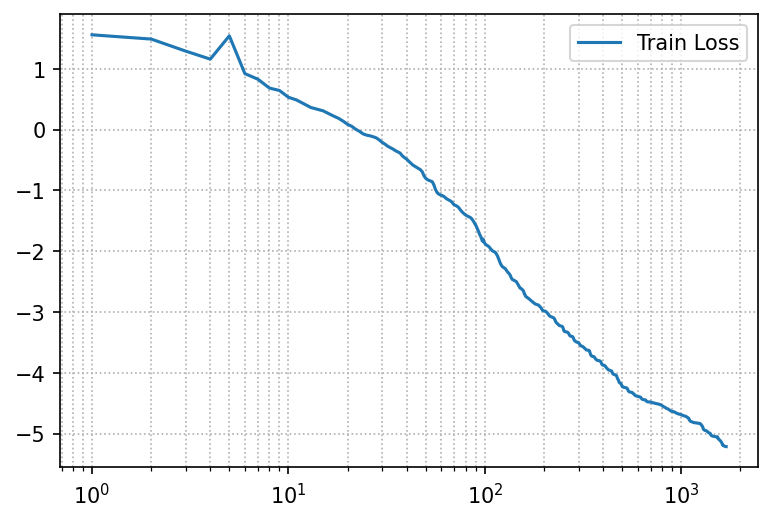

In [17]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

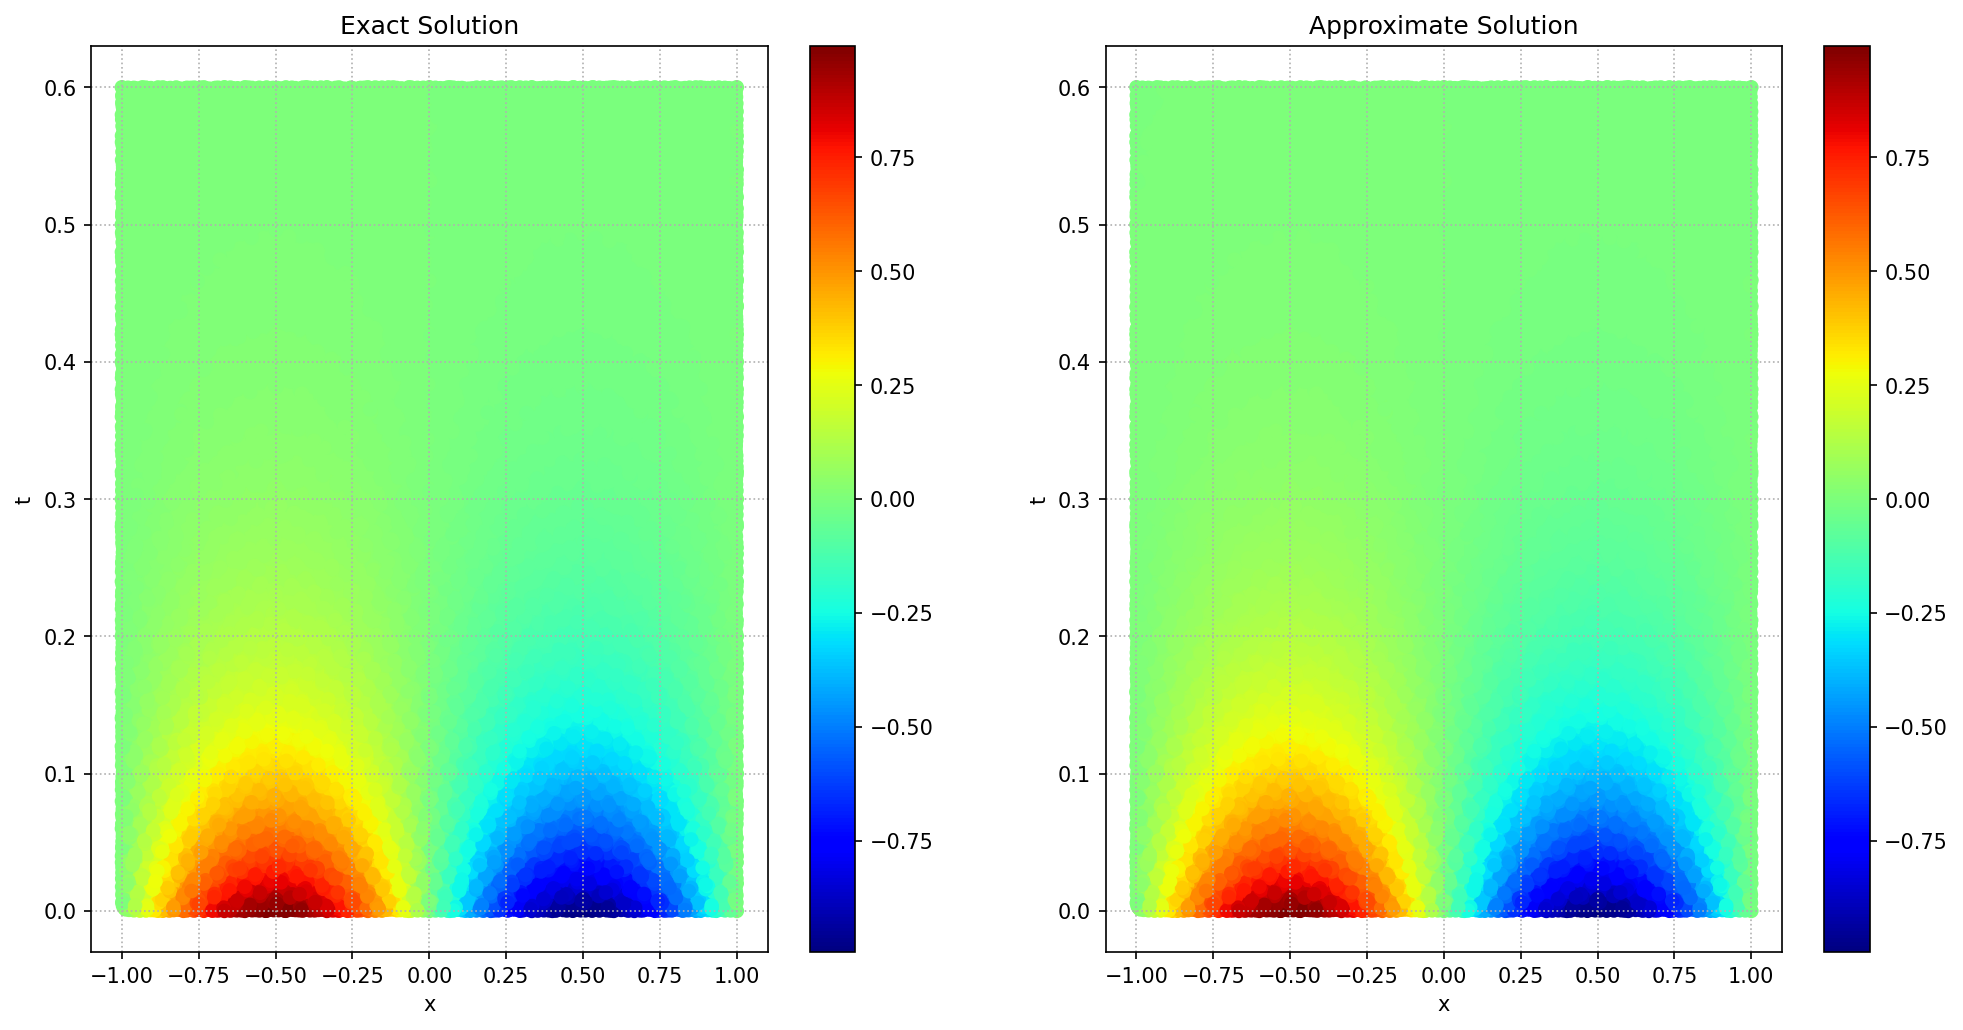

L2 Relative Error Norm:  0.07061528414487839 %


In [18]:
pinn.plotting()